<b>Forecasting experimentation 2 - Flight passenger data</b>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [24]:
df = sns.load_dataset("flights")

In [25]:
df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


<b>Before going further, we have to scale the passengers-value to be between 0 and 1</b>

In [26]:
scaler = MinMaxScaler()
df[["passengers"]] = scaler.fit_transform(df[["passengers"]])
df.index = df.index * 0.1 + 1

<b>X_train, y_train, X_test, y_test</b>

In [27]:
# let's figure out a proper cutoff point
# for train/test-split
cutoff = int(len(df) * 0.70)

X_train = df.index[0:cutoff]
y_train = df["passengers"].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df["passengers"].iloc[cutoff:]

# convert to NumPy array-format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Note to self: is this necessary?
n_features = 1
train_series = y_train.reshape((len(y_train), n_features))
test_series = y_test.reshape((len(y_test), n_features))

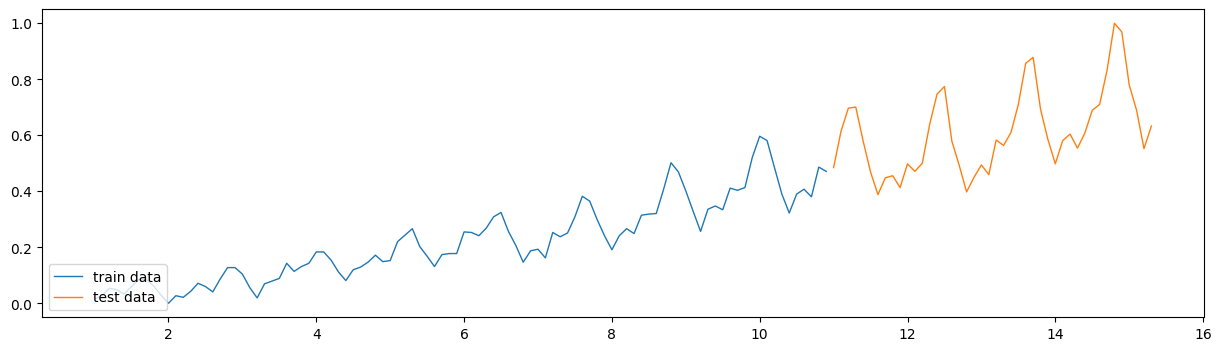

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test, y_test,  lw=1, label='test data')
ax.legend(loc="lower left")
plt.show()

In [29]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# this is the timestep size
# so if we have 1000 points, and look_back is 20 => 50 time steps
look_back  = 12

# using 1 => using time steps
# anything above 1 => windowing (instead of time steps)
window_size = 1

# the amount of data fed into the neural network while training
# the bigger it is, the faster the training
# but with forecasts it also affects the performance
batch_size = 10

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [30]:
from keras.models import Sequential
from keras.layers import Dense

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# effectiveness depends on the situation/dataset
from keras.layers import LSTM
from keras.layers import SimpleRNN

# make a simple LSTM network
# number of neurons can be adjusted
# you can also try SimpleRNN
model = Sequential()
model.add(LSTM(24, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# start training the model, use also validation data for metrics later
model.fit(train_generator,epochs=100, verbose=1, validation_data=test_generator)

Epoch 1/100
9/9 [==============================] - 3s 69ms/step - loss: 0.0696 - val_loss: 0.3110
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0302 - val_loss: 0.1513
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0113 - val_loss: 0.0610
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0089 - val_loss: 0.0331
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0385
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0074 - val_loss: 0.0480
Epoch 7/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0068 - val_loss: 0.0482
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0411
Epoch 9/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0287
Epoch 10/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0057 - val_loss: 0.0286
Epoch 11/100
9/9 [=

<Axes: >

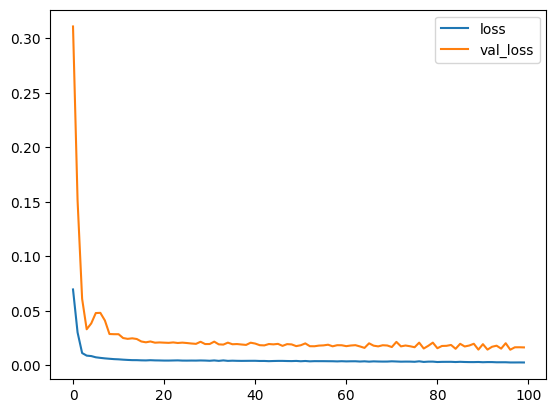

In [31]:
# training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

4/4 [==============================] - 0s 4ms/step


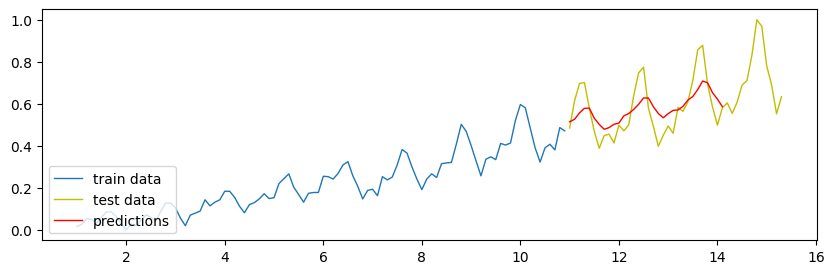

In [33]:
test_predictions  = model.predict(test_generator)

# this code is not optimal
# our code should instead scale based on the X_train / X_test
x = np.arange(11,14.2,0.1)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the trianing data to inspect the 
# predictions vs. test data separately
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test,y_test, lw=1, c='y', label='test data')
ax.plot(x,test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")
plt.show()